# Handling The Missing Cells In Dataset

# Central Tendencies:
* mean
* median
* mode

and to manipulate the missing data there are two ways:
* Imputation
* Dropping


In [ ]:
# import the dependencies
import re
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from nltk.corpus import stopwords

#importing all types of stemmers.
from nltk.stem import RegexpStemmer
from nltk.stem import PorterStemmer 
from nltk.stem import SnowballStemmer
from nltk.stem import LancasterStemmer

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score, plot_confusion_matrix

# import the classifiers
import tensorflow as tf
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

!pip install yellowbrick
from yellowbrick.text import FreqDistVisualizer

In [ ]:
# loading data set to pandas data frame DS.
dataset = pd.read_csv('/content/train.csv')
# reorder columns.
dataset = dataset[['Id', 'following', 'followers', 'actions', 'is_retweet', 'Tweet', 'location', 'Type']]
# download the set of stopwords.
nltk.download('stopwords')
# len(dataset['Tweet'].unique())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Imputation method
edited_dataset = pd.read_csv('/content/train.csv')
edited_dataset = edited_dataset[['Id', 'following', 'followers', 'actions', 'is_retweet', 'Tweet', 'location', 'Type']]
edited_dataset = edited_dataset.drop(columns=['location'])
edited_dataset['following'].fillna(edited_dataset['following'].median(), inplace=True)
edited_dataset['followers'].fillna(edited_dataset['followers'].median(), inplace=True)
edited_dataset['actions'].fillna(edited_dataset['actions'].median(), inplace=True)
edited_dataset['is_retweet'].fillna(edited_dataset['is_retweet'].median(), inplace=True)
# edited_dataset['location'].fillna(edited_dataset['location'].mode(), inplace=True)

In [ ]:
# Dropping method
cleaned_dataset = pd.read_csv('/content/train.csv')
cleaned_dataset = cleaned_dataset[['Id', 'following', 'followers', 'actions', 'is_retweet', 'Tweet', 'location', 'Type']]
cleaned_dataset = cleaned_dataset.drop(columns=['location'])
cleaned_dataset = cleaned_dataset.dropna(how='any')

In [ ]:
# group the null values by the columns.
print(dataset.isnull().sum(), "\n")
print(edited_dataset.isnull().sum(), "\n")
print(cleaned_dataset.isnull().sum())

Id               0
following      145
followers       16
actions       2773
is_retweet       1
Tweet            0
location      1651
Type             0
dtype: int64 

Id            0
following     0
followers     0
actions       0
is_retweet    0
Tweet         0
Type          0
dtype: int64 

Id            0
following     0
followers     0
actions       0
is_retweet    0
Tweet         0
Type          0
dtype: int64


# Label Encoding and Data Sipliting

In [ ]:
# tranform the label set to numeric values.
label_encoder = LabelEncoder()
cleaned_dataset['Type'] = label_encoder.fit_transform(cleaned_dataset.Type)
edited_dataset['Type'] = label_encoder.fit_transform(edited_dataset.Type)

# sipliting the dataset into data and labels.
cleaned_x = cleaned_dataset.drop(columns=['Type'])
cleaned_y = cleaned_dataset['Type']

edited_x = edited_dataset.drop(columns=['Type'])
edited_y = edited_dataset['Type']

# sipliting dataset into training data and testing data.
edited_x_train, edited_x_test, edited_y_train, edited_y_test = train_test_split(edited_x, edited_y, test_size=0.2, random_state=3)
cleaned_x_train, cleaned_x_test, cleaned_y_train, cleaned_y_test = train_test_split(cleaned_x, cleaned_y, test_size=0.2, random_state=3)

print(cleaned_y.value_counts())
print(edited_y.value_counts())

1    5815
0    3269
Name: Type, dtype: int64
0    6153
1    5815
Name: Type, dtype: int64


# Standardize Data

In [ ]:
# standardize the numerical data.
scaler = StandardScaler().fit(edited_x_train.iloc[:, 1:5])
edited_x_train.iloc[:, 1:5] = scaler.transform(edited_x_train.iloc[:, 1:5])
edited_x_test.iloc[:, 1:5] = scaler.transform(edited_x_test.iloc[:, 1:5])

scaler2 = StandardScaler().fit(cleaned_x_train.iloc[:, 1:5])
cleaned_x_train.iloc[:, 1:5] = scaler2.transform(cleaned_x_train.iloc[:, 1:5])
cleaned_x_test.iloc[:, 1:5] = scaler2.transform(cleaned_x_test.iloc[:, 1:5])

In [ ]:
print(edited_x_train.std())
print(cleaned_x_train.std())

Id            3634.622256
following        1.000052
followers        1.000052
actions          1.000052
is_retweet       1.000052
dtype: float64
Id            3634.346708
following        1.000069
followers        1.000069
actions          1.000069
is_retweet       1.000069
dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


In [ ]:
# handle imbalanced data.
normal_tweets = cleaned_dataset[cleaned_dataset.Type == 0]
spam_tweets = cleaned_dataset[cleaned_dataset.Type == 1]
balanced_datset = pd.concat([normal_tweets, spam_tweets.sample(len(normal_tweets))], axis = 0)

In [ ]:
# apply stemming and removing the non alphabetical chars and URLs from text.
#  References:
#   [*] https://stackoverflow.com/questions/11331982/how-to-remove-any-url-within-a-string-in-python/11332580
#   [*] https://stackoverflow.com/questions/1276764/stripping-everything-but-alphanumeric-chars-from-a-string-in-python

porter_stemmer = PorterStemmer()
lancaster_stemmer = LancasterStemmer()
snowball_stemmer = SnowballStemmer(language='english')
regexp_stemmer = RegexpStemmer('ing$|s$|e$|able$', min=4)

def stemming(content):
  stemmed_content = re.sub(r'^https?:\/\/.*[\r\n]*', '',  content, flags=re.MULTILINE)  # remove URL.
  stemmed_content = re.sub('http', '', content)  
  stemmed_content = re.sub('www', '', content)
  stemmed_content = re.sub('com', '', content)
  stemmed_content = re.sub('[^a-zA-Z]', ' ', content)  # remove non alphabetical chars.
  stemmed_content = stemmed_content.lower()
  stemmed_content = stemmed_content.split()
  stemmed_content = [regexp_stemmer.stem(word) for word in stemmed_content if len(word) > 2 and not word in stopwords.words('english')]
  stemmed_content = ' '.join(stemmed_content)
  return stemmed_content

In [ ]:
# apply stemming.
balanced_datset['Tweet'] = balanced_datset['Tweet'].apply(stemming)
# to drop labels from x => x = dataset.drop(columns=['label'])

In [ ]:
x = balanced_datset['Tweet'].values
y = balanced_datset['Type'].values

# converting the textual data to feature vectors
vectorizer = TfidfVectorizer()
x = vectorizer.fit_transform(x)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


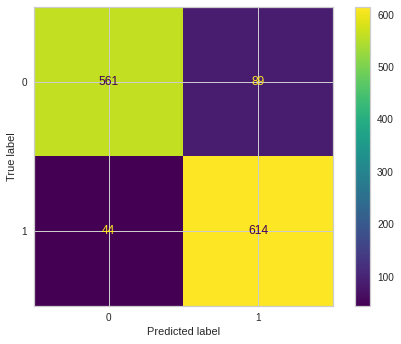

In [ ]:
classifier = LogisticRegression()
classifier.fit(x_train, y_train)
spam_prediction_LR = classifier.predict(x_test)
plot_confusion_matrix(classifier, x_test, y_test)
plt.show()

In [ ]:
classifier = BernoulliNB()
classifier.fit(x_train.toarray(), y_train)
spam_prediction_GNB = classifier.predict(x_test.toarray())


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


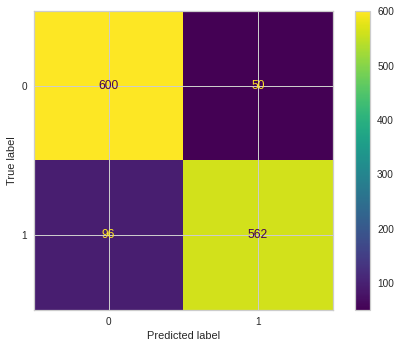

In [ ]:
classifier = RandomForestClassifier(n_estimators=10, criterion='entropy', random_state=0)
classifier.fit(x_train, y_train)
spam_prediction_RF = classifier.predict(x_test)
plot_confusion_matrix(classifier, x_test, y_test)
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


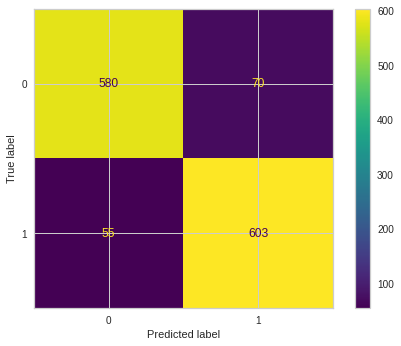

In [ ]:
classifier = SVC(kernel='linear', random_state=0)
classifier.fit(x_train, y_train)
plot_confusion_matrix(classifier, x_test, y_test)
plt.show()
spam_prediction_SVC = classifier.predict(x_test)

In [ ]:
# Neural Network.
# Initializing the ANN.
ann = tf.keras.models.Sequential()

# Adding the input layer.
ann.add(tf.keras.layers.Dense(units=6, activation='sigmoid'))

# Adding the hidden layer.
ann.add(tf.keras.layers.Dense(units=160, activation='sigmoid'))

# Adding the output layer.
ann.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

# Compiling the ANN.
ann.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Training the ANN on the Training set.
ann.fit(x_train, y_train, batch_size=32, epochs=10)

# Testing the ANN on the testing set.
spam_prediction_ANN = ann.predict(x_test)
spam_prediction_ANN = (spam_prediction_ANN > 0.5)


Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape:0", shape=(None, 6), dtype=float32), dense_shape=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


164/164 [==============================] - 4s 7ms/step - loss: 0.6952 - accuracy: 0.5128
Epoch 2/10
164/164 [==============================] - 1s 8ms/step - loss: 0.6862 - accuracy: 0.5564
Epoch 3/10
164/164 [==============================] - 1s 8ms/step - loss: 0.6581 - accuracy: 0.6912
Epoch 4/10
164/164 [==============================] - 1s 9ms/step - loss: 0.5645 - accuracy: 0.9220
Epoch 5/10
164/164 [==============================] - 2s 10ms/step - loss: 0.4020 - accuracy: 0.9505
Epoch 6/10
164/164 [==============================] - 2s 10ms/step - loss: 0.2487 - accuracy: 0.9663
Epoch 7/10
164/164 [==============================] - 1s 9ms/step - loss: 0.1593 - accuracy: 0.9730
Epoch 8/10
164/164 [==============================] - 1s 8ms/step - loss: 0.1096 - accuracy: 0.9826
Epoch 9/10
164/164 [==============================] - 1s 8ms/step - loss: 0.0796 - accuracy: 0.9870
Epoch 10/10
164/164 [==============================] - 2s 9ms/step - loss: 0.0596 - accuracy: 0.9916


In [ ]:
def print_confusion_matrix(y_test, spam_prediction, string):
    cm = confusion_matrix(y_test, spam_prediction)
    tp = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    tn = cm[1][1]
    pr = tp / (tp + fp)
    rec = tp / (tp + fn)
    print("========= The Confusion Matrix of", string, "========")
    print("           True Positive  =", tp)
    print("           False Positive =", fp)
    print("           False Negative =", fn)
    print("           True Negative  =", tn)
    print("           Precision =", round(pr * 100, 3))
    print("           Recall    =", round(rec * 100, 3))
    print("           F1-score  =", round((2 * pr * rec) / (pr + rec) * 100, 3))
    print("           Accuracy  =", round(accuracy_score(y_test, spam_prediction) * 100, 3))
    print("==============================================")
print_confusion_matrix(y_test, spam_prediction_LR, "LR")
print_confusion_matrix(y_test, spam_prediction_GNB, "GNB")
print_confusion_matrix(y_test, spam_prediction_RF, "RF")
print_confusion_matrix(y_test, spam_prediction_SVC, "SVC")
print_confusion_matrix(y_test, spam_prediction_ANN, "ANN")




========= The Confusion Matrix of LR ========
           True Positive  = 561
           False Positive = 89
           False Negative = 44
           True Negative  = 614
           Precision = 86.308
           Recall    = 92.727
           F1-score  = 89.402
           Accuracy  = 89.832
========= The Confusion Matrix of GNB ========
           True Positive  = 576
           False Positive = 74
           False Negative = 68
           True Negative  = 590
           Precision = 88.615
           Recall    = 89.441
           F1-score  = 89.026
           Accuracy  = 89.144
========= The Confusion Matrix of RF ========
           True Positive  = 600
           False Positive = 50
           False Negative = 96
           True Negative  = 562
           Precision = 92.308
           Recall    = 86.207
           F1-score  = 89.153
           Accuracy  = 88.838
========= The Confusion Matrix of SVC ========
           True Positive  = 580
           False Positive = 70
           Fa